# Training the QuickWand Model

This Jupyter Lab was based on Training Your Custom Magic Wand Model by Pete Warden.  https://colab.research.google.com/github/tinyMLx/colabs/blob/master/4-8-11-CustomMagicWand.ipynb

In [1]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory

from IPython.display import Image, display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import shutil
import PIL
import math
import glob
import json
import os


In [2]:
# Define filenames and set up directory structure
MODELS_DIR = 'models'
if not os.path.exists(MODELS_DIR):
  os.mkdir(MODELS_DIR)
SAVED_MODEL_FILENAME = os.path.join(MODELS_DIR, "quick_wand")
FLOAT_TFL_MODEL_FILENAME = os.path.join(MODELS_DIR, "quick_wand_float.tfl")
QUANTIZED_TFL_MODEL_FILENAME = os.path.join(MODELS_DIR, "quick_wand.tfl")
TFL_CC_MODEL_FILENAME = os.path.join(MODELS_DIR, "quick_wand.cc")

DATASET_DIR =  'dataset'
if not os.path.exists(DATASET_DIR):
  os.mkdir(DATASET_DIR)
TRAIN_DIR = os.path.join(DATASET_DIR, "train")
VAL_DIR = os.path.join(DATASET_DIR, "validation")
TEST_DIR = os.path.join(DATASET_DIR, "test")
!rm -rf sample_data

CHKPT_DIR =  'checkpoints'
if not os.path.exists(CHKPT_DIR):
  os.mkdir(CHKPT_DIR)

# Train Split
TEST_PERCENTAGE = 10
VALIDATION_PERCENTAGE = 20
TRAIN_PERCENTAGE = 100 - (TEST_PERCENTAGE + VALIDATION_PERCENTAGE)

In [3]:
NUM_GESTURES = 5 # UPDATE THIS WITH THE NUMBER OF UNIQUE GESTURES IN YOUR DATASET #

In [4]:
dataset_jsons = DATASET_DIR + "/*.json"
allstrokes = []
strokes = []
for filename in glob.glob(dataset_jsons):
  with open(filename, "r") as file:
    file_contents = file.read()
  file_data = json.loads(file_contents)
  for stroke in file_data["strokes"]:
    stroke["filename"] = filename
    stroke["label"] = filename.replace(DATASET_DIR + "\\", "").replace(".json","").replace("v2","")
    strokes.append(stroke)

In [5]:
# Helper function to visualize the data
def plot_stroke(stroke):
  x_array = []
  y_array = []
  for coords in stroke["strokePoints"]:
    x_array.append(coords["x"])
    y_array.append(coords["y"])

  fig = plt.figure(figsize=(12.8, 4.8))
  fig.suptitle(stroke["label"])

  ax = fig.add_subplot(131)
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.set_xlim(-0.6, 0.6)
  ax.set_ylim(-0.6, 0.6)
  ax.plot(x_array, y_array)

  plt.show()

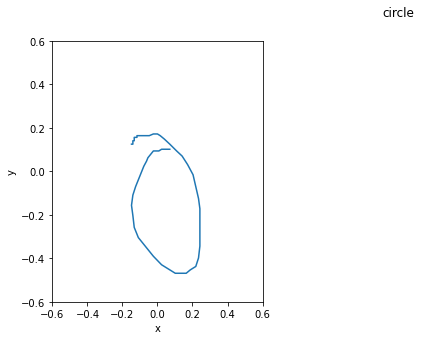

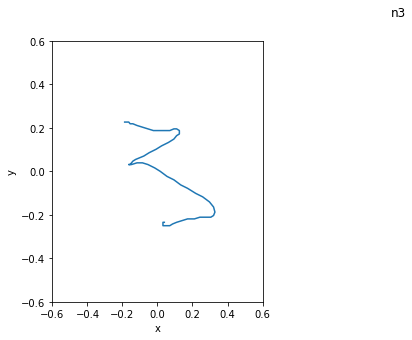

In [6]:
# Display a stroke from the strokes python variable
plot_stroke(strokes[11])
plot_stroke(strokes[628])
#print(strokes)

In [7]:
FIXED_POINT = 256

def mul_fp(a, b):
  return (a * b) / FIXED_POINT

def div_fp(a, b):
  if b == 0:
    b = 1
  return (a * FIXED_POINT) / b

def float_to_fp(a):
  return math.floor(a * FIXED_POINT)

def norm_to_coord_fp(a, range_fp, half_size_fp):
  a_fp = float_to_fp(a)
  norm_fp = div_fp(a_fp, range_fp)
  return mul_fp(norm_fp, half_size_fp) + half_size_fp

def round_fp_to_int(a):
  return math.floor((a + (FIXED_POINT / 2)) / FIXED_POINT)

def gate(a, min, max):
  if a < min:
    return min
  elif a > max:
    return max
  else:
    return a

def rasterize_stroke(stroke_points, x_range, y_range, width, height):
  num_channels = 3
  buffer_byte_count = height * width * num_channels
  buffer = bytearray(buffer_byte_count)

  width_fp = width * FIXED_POINT
  height_fp = height * FIXED_POINT
  half_width_fp = width_fp / 2
  half_height_fp = height_fp / 2
  x_range_fp = float_to_fp(x_range)
  y_range_fp = float_to_fp(y_range)

  t_inc_fp = FIXED_POINT / len(stroke_points)

  one_half_fp = (FIXED_POINT / 2)

  for point_index in range(len(stroke_points) - 1):
    start_point = stroke_points[point_index]
    end_point = stroke_points[point_index + 1]
    start_x_fp = norm_to_coord_fp(start_point["x"], x_range_fp, half_width_fp)
    start_y_fp = norm_to_coord_fp(-start_point["y"], y_range_fp, half_height_fp)
    end_x_fp = norm_to_coord_fp(end_point["x"], x_range_fp, half_width_fp)
    end_y_fp = norm_to_coord_fp(-end_point["y"], y_range_fp, half_height_fp)
    delta_x_fp = end_x_fp - start_x_fp
    delta_y_fp = end_y_fp - start_y_fp

    t_fp = point_index * t_inc_fp
    white = 255 
    if abs(delta_x_fp) > abs(delta_y_fp):
      line_length = abs(round_fp_to_int(delta_x_fp))
      if delta_x_fp > 0:
        x_inc_fp = 1 * FIXED_POINT
        y_inc_fp = div_fp(delta_y_fp, delta_x_fp)
      else:
        x_inc_fp = -1 * FIXED_POINT
        y_inc_fp = -div_fp(delta_y_fp, delta_x_fp)
    else:
      line_length = abs(round_fp_to_int(delta_y_fp))
      if delta_y_fp > 0:
        y_inc_fp = 1 * FIXED_POINT
        x_inc_fp = div_fp(delta_x_fp, delta_y_fp)
      else:
        y_inc_fp = -1 * FIXED_POINT
        x_inc_fp = -div_fp(delta_x_fp, delta_y_fp)
    for i in range(line_length + 1):
      x_fp = start_x_fp + (i * x_inc_fp)
      y_fp = start_y_fp + (i * y_inc_fp)
      x = round_fp_to_int(x_fp)
      y = round_fp_to_int(y_fp)
      if (x < 0) or (x >= width) or (y < 0) or (y >= height):
        continue
      buffer_index = (y * width * num_channels) + (x * num_channels)
      buffer[buffer_index + 0] = white
      buffer[buffer_index + 1] = white
      buffer[buffer_index + 2] = white
  
  np_buffer = np.frombuffer(buffer, dtype=np.uint8).reshape(height, width, num_channels)
        
  return np_buffer

In [8]:
X_RANGE = 0.6
Y_RANGE = 0.6

def ensure_empty_dir(dirname):
  dirpath = Path(dirname)
  if dirpath.exists() and dirpath.is_dir():
    shutil.rmtree(dirpath)
  dirpath.mkdir()

def augment_points(points, move_range, scale_range, rotate_range):
  move_x = np.random.uniform(low=-move_range, high=move_range)
  move_y = np.random.uniform(low=-move_range, high=move_range)
  scale = np.random.uniform(low=1.0-scale_range, high=1.0+scale_range)
  rotate = np.random.uniform(low=-rotate_range, high=rotate_range)


  new_points = []
  for point in points:
    old_x = point["x"]
    old_y = point["y"]
    new_x = old_x+ move_x
    new_y =  old_y + move_y
    new_points.append({"x": new_x, "y": new_y})

  return new_points

def save_strokes_as_images(strokes, root_folder, width, height, augment_count):
  ensure_empty_dir(root_folder)
  labels = set()
  for stroke in strokes:
    labels.add(stroke["label"].lower())
  for label in labels:
    label_path = Path(root_folder, label)
    ensure_empty_dir(label_path)

  label_counts = {}
  for stroke in strokes:
    points = stroke["strokePoints"]
    label = stroke["label"].lower()
    if label == "":
      raise Exception("Missing label for %s:%d" % (stroke["filename"], stroke["index"]))
    if label not in label_counts:
      label_counts[label] = 0
    label_count = label_counts[label]
    label_counts[label] += 1
    raster = rasterize_stroke(points, X_RANGE, Y_RANGE, width, height)
    image = PIL.Image.fromarray(raster)
    image.save(Path(root_folder, label, str(label_count) + ".png"))
    for i in range(augment_count):
      augmented_points = augment_points(points, 0.1, 0.1, 0)
      raster = rasterize_stroke(augmented_points, X_RANGE, Y_RANGE, width, height)
      image = PIL.Image.fromarray(raster)
      image.save(Path(root_folder, label, str(label_count) + "_a" + str(i) + ".png"))
  return labels

In [9]:
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32

In [10]:

shuffled_strokes = strokes
np.random.shuffle(shuffled_strokes)

test_count = math.floor((len(shuffled_strokes) * TEST_PERCENTAGE) / 100)
validation_count = math.floor((len(shuffled_strokes) * VALIDATION_PERCENTAGE) / 100)
test_strokes = shuffled_strokes[0:test_count]
validation_strokes = shuffled_strokes[test_count:(test_count + validation_count)]
train_strokes = shuffled_strokes[(test_count + validation_count):]


labels_test  = save_strokes_as_images(test_strokes, TEST_DIR, IMAGE_WIDTH, IMAGE_HEIGHT, 10)
labels_val   = save_strokes_as_images(validation_strokes, VAL_DIR, IMAGE_WIDTH, IMAGE_HEIGHT, 10)
labels_train = save_strokes_as_images(train_strokes, TRAIN_DIR, IMAGE_WIDTH, IMAGE_HEIGHT, 10)

In [11]:
labels = sorted(labels_test.union(labels_val).union(labels_train))
# get the conversion from label string to int
labelToInt = {}
currInt = 0
for label in labels:
  labelToInt[label] = currInt
  currInt = currInt + 1
intToLabel = {v: k for k, v in labelToInt.items()}
print(intToLabel)

{0: 'circle', 1: 'greaterthan', 2: 'lessthan', 3: 'n3', 4: 'r3'}


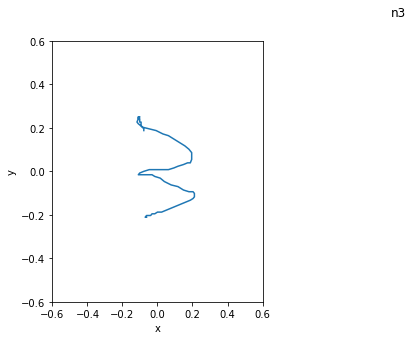

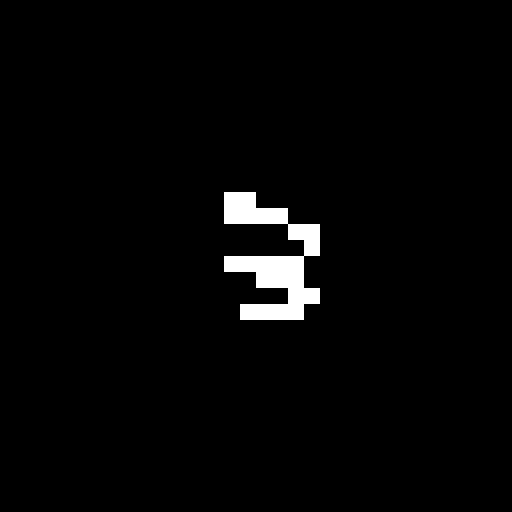

In [12]:
StrokeNum = 9
plot_stroke(strokes[StrokeNum])
raster = rasterize_stroke(strokes[StrokeNum]["strokePoints"], 1,1, 32, 32)
PIL.Image.fromarray(raster).resize((512, 512), PIL.Image.NEAREST)

In [13]:
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
train_dataset = image_dataset_from_directory(
    directory=TRAIN_DIR,
    label_mode='categorical',
    shuffle=True,
    batch_size=32,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT))

val_dataset = image_dataset_from_directory(
    directory=VAL_DIR,
    label_mode='categorical',
    shuffle=True,
    batch_size=32,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT))





Found 7326 files belonging to 5 classes.
Found 2079 files belonging to 5 classes.


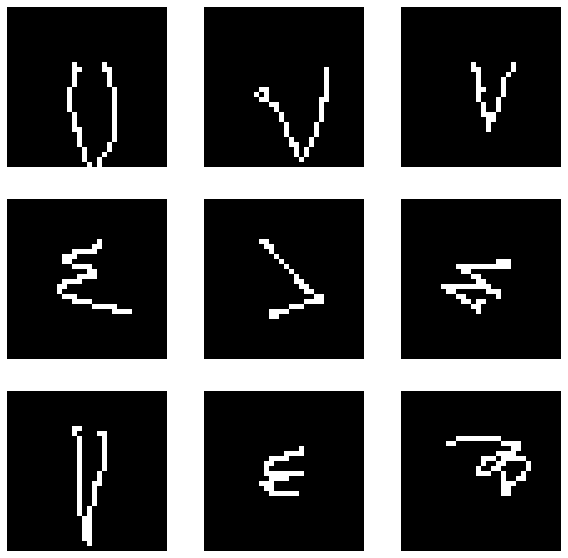

In [14]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

## Define Model



In [15]:
NUM_GESTURES = 5

In [16]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(8, 16, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Conv2D(16, 8, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.2)(x)
    

    
    
    
    
    x= layers.GlobalAveragePooling2D()(x)
    
    activation = "softmax"
    units = num_classes

    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

model = make_model(input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3), num_classes=NUM_GESTURES)

## Training Model


In [17]:
EPOCHS = 50


model.compile(
    optimizer="Adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

# Run training
history = model.fit(train_dataset, epochs=EPOCHS, validation_data=val_dataset,shuffle=True)

Epoch 1/50
229/229 [==============================] - 10s 43ms/step - loss: 1.1321 - accuracy: 0.5530 - val_loss: 1.0900 - val_accuracy: 0.5565
Epoch 2/50
229/229 [==============================] - 5s 21ms/step - loss: 0.7082 - accuracy: 0.7703 - val_loss: 0.5372 - val_accuracy: 0.9384
Epoch 3/50
229/229 [==============================] - 5s 21ms/step - loss: 0.4548 - accuracy: 0.8810 - val_loss: 0.3013 - val_accuracy: 0.9774
Epoch 4/50
229/229 [==============================] - 5s 21ms/step - loss: 0.2972 - accuracy: 0.9215 - val_loss: 0.1304 - val_accuracy: 0.9880
Epoch 5/50
229/229 [==============================] - 5s 21ms/step - loss: 0.2330 - accuracy: 0.9358 - val_loss: 0.0880 - val_accuracy: 0.9875
Epoch 6/50
229/229 [==============================] - 5s 21ms/step - loss: 0.2041 - accuracy: 0.9401 - val_loss: 0.0917 - val_accuracy: 0.9817
Epoch 7/50
229/229 [==============================] - 5s 22ms/step - loss: 0.1725 - accuracy: 0.9498 - val_loss: 0.0514 - val_accuracy: 0.992

In [18]:
# save the model file
model.save(SAVED_MODEL_FILENAME)

INFO:tensorflow:Assets written to: models\quick_wand\assets


## Test your TensorFlow Model

Lets now test out the TF model on the test dataset. We'll print out any gesture we get wrong as well as the percentage of known gestures correct as well as the number of gestures that were marked as unknown.

Testing Gesture:  circle  with datasize:  220
Testing Gesture:  greaterthan  with datasize:  253
Testing Gesture:  lessthan  with datasize:  132
Testing Gesture:  n3  with datasize:  264
n3 4 0.9879495
[n3] expected, [r3] found with score [0.987949]


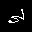

n3 4 0.8882614
[n3] expected, [r3] found with score [0.888261]


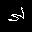

n3 0 0.7769927
[n3] expected, [circle] found with score [0.776993]


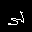

n3 4 0.95937365
[n3] expected, [r3] found with score [0.959374]


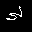

n3 0 0.85084057
[n3] expected, [circle] found with score [0.850841]


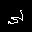

n3 4 0.97734433
[n3] expected, [r3] found with score [0.977344]


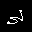

n3 4 0.9619802
[n3] expected, [r3] found with score [0.961980]


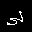

Testing Gesture:  r3  with datasize:  165
99.3% correct (N=1030, 4 unknown)


In [19]:
SCORE_THRESHOLD = 0.75 # Confidence threshold to discard an image as "unknown"

def predict_image(model, filename):
  img = keras.preprocessing.image.load_img(filename, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)  # Create batch axis
  predictions = model.predict(img_array).flatten()
  predicted_label_index = np.argmax(predictions)
  predicted_score = predictions[predicted_label_index]
  return (predicted_label_index, predicted_score)

correct_count = 0
wrong_count = 0
discarded_count = 0
for label_dir in glob.glob(TEST_DIR + "/*"):
  label = label_dir.replace(TEST_DIR + "\\", "")
  print("Testing Gesture: ",label," with datasize: ",len(glob.glob(label_dir + "/*.png")))
  for filename in glob.glob(label_dir + "/*.png"):
    index, score = predict_image(model, filename)
    if score < SCORE_THRESHOLD:
      discarded_count += 1
      continue
    if index == labelToInt[label]:
      correct_count += 1
    else:
      wrong_count += 1
      print(label,index,score)
      print("[%s] expected, [%s] found with score [%f]" % (label, intToLabel[index], score))
      display(Image(filename=filename))

if correct_count + wrong_count == 0:
  print("All images marked as unknown!")
else:
  correct_percentage = (correct_count / (correct_count + wrong_count)) * 100
  print("%.1f%% correct (N=%d, %d unknown)" % (correct_percentage, (correct_count + wrong_count), discarded_count))

If you'd like to manually evaluate particular images you can uncomment, update, and run the below cell and select an image from the test folder.

## TF Lite Micro Model

In [20]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
model_no_quant_tflite = converter.convert()

# Save the model to disk
open(FLOAT_TFL_MODEL_FILENAME, "wb").write(model_no_quant_tflite)

def representative_dataset():
  for filename in glob.glob(TEST_DIR + "/*/*.png"):
    img = keras.preprocessing.image.load_img(filename, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis for images, labels in train_ds.take(1):
    yield([img_array])
# Set the optimization flag.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Enforce integer only quantization
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
# Provide a representative dataset to ensure we quantize correctly.
converter.representative_dataset = representative_dataset
model_tflite = converter.convert()

# Save the model to disk
open(QUANTIZED_TFL_MODEL_FILENAME, "wb").write(model_tflite)

INFO:tensorflow:Assets written to: C:\Users\Natty\AppData\Local\Temp\tmp7d6kn3uo\assets
INFO:tensorflow:Assets written to: C:\Users\Natty\AppData\Local\Temp\tmpjnxbzb09\assets


INFO:tensorflow:Assets written to: C:\Users\Natty\AppData\Local\Temp\tmpjnxbzb09\assets


18096

## Test Models


In [21]:
def predict_tflite(tflite_model, filename):
  img = keras.preprocessing.image.load_img(filename, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)

  # Initialize the TFLite interpreter
  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  # If required, quantize the input layer (from float to integer)
  input_scale, input_zero_point = input_details["quantization"]
  if (input_scale, input_zero_point) != (0.0, 0):
    img_array = np.multiply(img_array, 1.0 / input_scale) + input_zero_point
    img_array = img_array.astype(input_details["dtype"])
  
  # Invoke the interpreter
  interpreter.set_tensor(input_details["index"], img_array)
  interpreter.invoke()
  pred = interpreter.get_tensor(output_details["index"])[0]
  
  # If required, dequantized the output layer (from integer to float)
  output_scale, output_zero_point = output_details["quantization"]
  if (output_scale, output_zero_point) != (0.0, 0):
    pred = pred.astype(np.float32)
    pred = np.multiply((pred - output_zero_point), output_scale)
  
  predicted_label_index = np.argmax(pred)
  predicted_score = pred[predicted_label_index]
  return (predicted_label_index, predicted_score)

In [22]:
def run_tflite_test(model_file):
  correct_count = 0
  wrong_count = 0
  discarded_count = 0
  for label_dir in glob.glob(TEST_DIR + "/*"):
    label = label_dir.replace(TEST_DIR + "\\", "")
    print("Testing Gesture: ",label," with datasize: ",len(glob.glob(label_dir + "/*.png")))
    for filename in glob.glob(label_dir + "/*.png"):
      index, score = predict_tflite(model_file, filename)
      if score < 0.75:
        discarded_count += 1
        continue
      if index == labelToInt[label]:
        correct_count += 1
      else:
        wrong_count += 1
        print("[%s] expected, [%s] found with score [%f]" % (label, intToLabel[index], score))
        display(Image(filename=filename))

  correct_percentage = (correct_count / (correct_count + wrong_count)) * 100

  print("%.1f%% correct (N=%d, %d unknown)" % (correct_percentage, (correct_count + wrong_count), discarded_count))

Testing Gesture:  circle  with datasize:  220
Testing Gesture:  greaterthan  with datasize:  253
Testing Gesture:  lessthan  with datasize:  132
Testing Gesture:  n3  with datasize:  264
[n3] expected, [r3] found with score [0.988281]


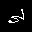

[n3] expected, [r3] found with score [0.863281]


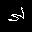

[n3] expected, [circle] found with score [0.773438]


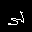

[n3] expected, [r3] found with score [0.949219]


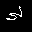

[n3] expected, [circle] found with score [0.824219]


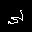

[n3] expected, [r3] found with score [0.976562]


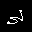

[n3] expected, [r3] found with score [0.964844]


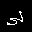

Testing Gesture:  r3  with datasize:  165
99.3% correct (N=1030, 4 unknown)


In [23]:
run_tflite_test(model_tflite)

If you'd like to manually evaluate particular images you can uncomment, update, and run the below cell and select an image from the test folder.

In [24]:
# Convert to a C source file, i.e, a TensorFlow Lite for Microcontrollers model
!xxd -i {QUANTIZED_TFL_MODEL_FILENAME} > {TFL_CC_MODEL_FILENAME}

That's it! You've successfully converted your TensorFlow Lite model into a TensorFlow Lite for Microcontrollers model! Run the cell below to print out its contents which we'll need for our next step, deploying the model using the Arudino IDE!

In [25]:
!cat {TFL_CC_MODEL_FILENAME}

unsigned char models_quick_wand_tfl[] = {
  0x20, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x00, 0x00, 0x00, 0x00,
  0x14, 0x00, 0x20, 0x00, 0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00,
  0x0c, 0x00, 0x00, 0x00, 0x08, 0x00, 0x04, 0x00, 0x14, 0x00, 0x00, 0x00,
  0x1c, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00, 0x4c, 0x00, 0x00, 0x00,
  0xe0, 0x39, 0x00, 0x00, 0xf0, 0x39, 0x00, 0x00, 0x18, 0x46, 0x00, 0x00,
  0x03, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00,
  0x0c, 0x00, 0x00, 0x00, 0x08, 0x00, 0x0c, 0x00, 0x08, 0x00, 0x04, 0x00,
  0x08, 0x00, 0x00, 0x00, 0x0e, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00,
  0x13, 0x00, 0x00, 0x00, 0x6d, 0x69, 0x6e, 0x5f, 0x72, 0x75, 0x6e, 0x74,
  0x69, 0x6d, 0x65, 0x5f, 0x76, 0x65, 0x72, 0x73, 0x69, 0x6f, 0x6e, 0x00,
  0x0f, 0x00, 0x00, 0x00, 0x90, 0x39, 0x00, 0x00, 0x88, 0x39, 0x00, 0x00,
  0x70, 0x39, 0x00, 0x00, 0x60, 0x21, 0x00, 0x00, 0x30, 0x21, 0x00, 0x00,
  0x20, 0x01, 0x00, 0x00, 0xd0, 0x00, 0x00, 0x00, 0x70, 0x00, 0x00, 0x